## Testing model for bias
Running test on two decks with randomly selected cards from the same Goblin Minion bucket.

Outcome should be 50/50 win/loss.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

df = pd.read_csv('data/results/mean_should_be_5.csv')
print(df.shape)
df.head()

(20, 3)


,generation,deck_uid,win_rate
0,0,kknmoknikklikjonknlkjnilnoikon,5
1,0,jojnmonojnnnnkiiljilnnomollnli,6
2,0,nnninmkjjillnmmlkkoknknilkmnno,5
3,0,nmkionklnmonkolnjiojolkollilni,3
4,0,ojjkkimklninjnonmimnnljjnommil,4


In [2]:
df["win_rate"].mean()

5.2

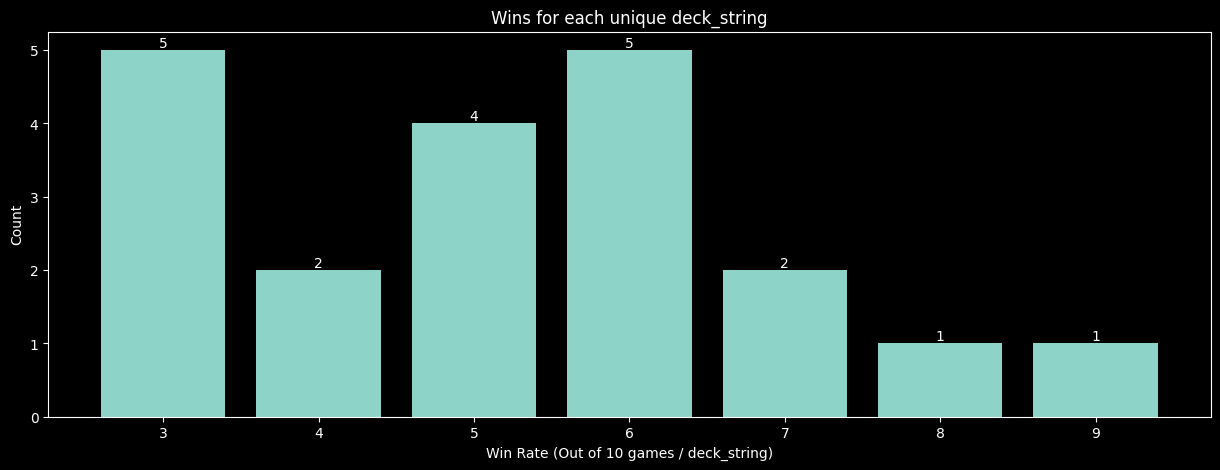

In [3]:
df = df.sort_values(by="win_rate")
grouped_df = df.groupby('win_rate').size().reset_index(name='count')

plt.figure(figsize=(15, 5))
bars = plt.bar(grouped_df['win_rate'], grouped_df['count'])

for bar, count in zip(bars, grouped_df['count']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha='center', va='bottom')

plt.xlabel('Win Rate (Out of 10 games / deck_string)')
plt.ylabel('Count')
plt.title('Wins for each unique deck_string')
plt.show()

## Top 3 cards - first iteration

These top 3 cards were found in all top performing decks (at least 5 wins / 10 games)

In [4]:
deck_uid_win_rate_5 = df[df['win_rate'] >= 5]['deck_uid'].tolist()

In [5]:
from collections import Counter
from card_wars.deck import DeckSerializer
from card_wars.import_cards import find_card

d = DeckSerializer()

all_strings = ''.join(deck_uid_win_rate_5)
char_count = Counter(all_strings)
most_common_chars = char_count.most_common(3)

for char, count in most_common_chars:
    percentage = (count / len(all_strings)) * 100
    card_id = (d.deserialize(short_string=char))
    card = find_card(card_id[0])

    print(f"{card}")
    print(f"On average in {percentage:.2f}% of top decks.\n")

Goblin Necromancer [2/2] Mana: 2
Deathrattle: Summon a 2/2 Goblin.
On average in 20.77% of top decks.

Prince Gobb [5/5] Mana: 5
Battlecry: Give all friendly Goblin [+2/+2].
On average in 14.36% of top decks.

Bobblin The Goblin [4/3] Mana: 3
On average in 13.85% of top decks.



Yeah, these are all kinda OP and synergize really well. **In this simulation there is no cap on card copies in a deck.**

Well, now we know the simulation *probably* isn't biased. Let's test it on something else before we start mutating generations.

---

## OG Random Goblin Deck vs Randomized Decks

In [6]:
import os
import pandas as pd
df = pd.read_csv('data/results/goblin_vs_random.csv')
print(df.shape)
df.head()

(420, 3)


,generation,deck_uid,win_rate
0,0,cbtbndrqotmrcpsimghsauuktjrqmo,1
1,0,fdkhtbmgjeannfqubmhareujijifmi,3
2,0,kminhsqbhohqhetngmuknitcdessdd,2
3,0,jeaomhgrojbdggsggnjmidkprqgrkc,1
4,0,udctfpehlbbpthpkuooppncubokhku,1


In [7]:
df["win_rate"].mean() # This should be much lower

1.588095238095238

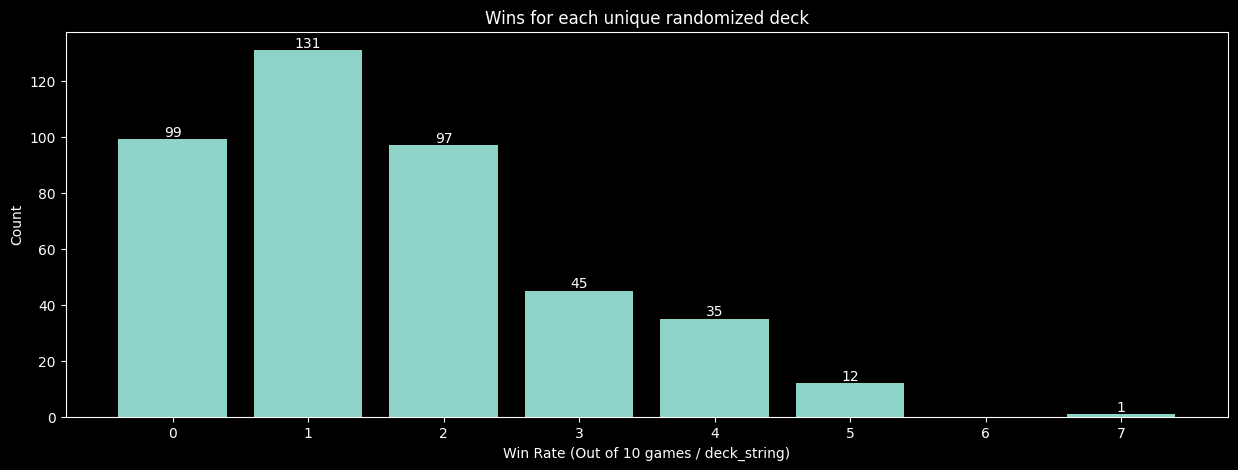

In [8]:
df = df.sort_values(by="win_rate")
grouped_df = df.groupby('win_rate').size().reset_index(name='count')

plt.figure(figsize=(15, 5))
bars = plt.bar(grouped_df['win_rate'], grouped_df['count'])

for bar, count in zip(bars, grouped_df['count']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha='center', va='bottom')

plt.title('Wins for each unique randomized deck')
plt.xlabel('Win Rate (Out of 10 games / deck_string)')
plt.ylabel('Count')
plt.show()

## Worst performing cards in Randomized Decks

In [9]:
worst = df[df['win_rate'] == 0]['deck_uid'].tolist() # Data from all decks with 0/10 wins.

d = DeckSerializer()

all_strings = ''.join(worst)
char_count = Counter(all_strings)
most_common_chars = char_count.most_common(7)

for char, count in most_common_chars:
    percentage = (count / len(all_strings)) * 100
    card_id = (d.deserialize(short_string=char))
    card = find_card(card_id[0])

    print(f"{card.name} in {percentage:.2f}% of bottom decks.")
    print(f"{card}\n")

Gramr in 6.67% of bottom decks.
Weapon(card_id='w000001', name='Gramr', description='The legendary sword forged by Odin and gifted to Sigmund, later used by Sigurd to kill the dragon Fafnir.', card_text='Does twice the damage to Dragns', mana_cost=4, attack=4, durability=2, ability=None)

Fire Blast in 6.03% of bottom decks.
Spell(card_id='sfir000', name='Fire Blast', description='A furious fireball.', card_text='', mana_cost=2, spell_type='Fire', target=0, damage=6)

War Axe in 5.72% of bottom decks.
Weapon(card_id='w000000', name='War Axe', description='Sturdy and reliable.', card_text='', mana_cost=2, attack=3, durability=2, ability=None)

Frost Nova in 5.25% of bottom decks.
Spell(card_id='sfro000', name='Frost Nova', description='AoE.', card_text='', mana_cost=4, spell_type='Frost', target=1, damage=2)

Dragonite in 5.19% of bottom decks.
Dragonite [7/7] Mana: 8
Battlecry: Deal 2 damage to all enemy minion. Divine Shield.

Praetorian Guard in 5.15% of bottom decks.
Praetorian Guar

This makes sense because the simulation and its programmed agents have lots of TODOs

- Gramr and War Axe - Agents will just equip them, never attack.

- Fire Blast is running through Target Assist function, which just randomly selects a taget. Meaning in some simulations, the agent is as likely to Fire Blast its own face as an enemy minion.

- Frost Nova is an AoE attack that theoretically should be good. However the logic for *when* to cast it has not yet been implemented.

- Dragonite is probably just too expensive to play most of the time. Although drawing it late game and playing it at the right time can be a game changer.

- Praetorian Guard: Probably not just worth it, given it's low attack. Taunt *might* be useful, given better implemented agent logic.

 Goblin Juggler: Just too random. Same thing with Target Assist.

 ---

Let's look at the deck that actually got 7 wins.

In [10]:
best_deck= df[df['win_rate'] >= 7]['deck_uid'].tolist()

best_deck

['bcflgnsonktlcaeinkthbmtnaidmkp']

In [11]:
from card_wars.deck import get_custom_deck
top_deck = get_custom_deck(d.deserialize(best_deck[0]))

print(top_deck)

Default Deck - [30/30] cards:

  1   mdra000   Dragonite
  1   mdra001   Hatchling
  1   mgno002   Gnomish Support Agent
  1   mgob003   Prince Gobb
  1   mgno003   Gnome Rider
  1   mgob005   Goblin Necromancer
  1   snat000   Wild Growth
  1   mgob006   Goblin Wingman
  2   mgob005   Goblin Necromancer
  1   mgob002   Goblin Juggler
  1   w000000   War Axe
  2   mgob003   Prince Gobb
  2   mdra001   Hatchling
  1   mbea000   Lil Teddy
  1   mgno001   Grandma Gnome
  1   mgob000   Goblin
  3   mgob005   Goblin Necromancer
  2   mgob002   Goblin Juggler
  2   w000000   War Axe
  1   mgno004   Grand Gnome
  2   mdra000   Dragonite
  1   mgob004   Goblin Gambler
  3   w000000   War Axe
  4   mgob005   Goblin Necromancer
  2   mbea000   Lil Teddy
  2   mgob000   Goblin
  1   mgno000   Gnome
  2   mgob004   Goblin Gambler
  3   mgob002   Goblin Juggler
  1   mneu000   Praetorian Guard



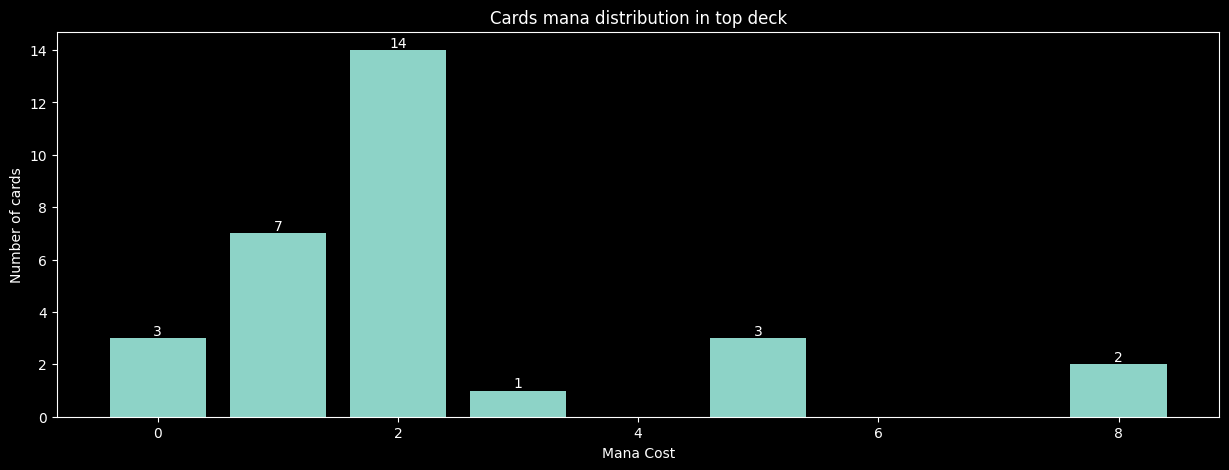

In [12]:
from card_wars.deck import Deck
top_deck.get_distribution()

count_dict = {}
for card in top_deck.get_distribution():
    count_dict[card] = count_dict.get(card, 0) + 1

sorted_counts = sorted(count_dict.items())
cards_sorted, counts_sorted = zip(*sorted_counts)

plt.figure(figsize=(15, 5))
bars = plt.bar(cards_sorted, counts_sorted)

for bar, count in zip(bars, counts_sorted):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count, ha='center', va='bottom')

plt.title('Cards mana distribution in top deck')
plt.xlabel('Mana Cost')
plt.ylabel('Number of cards')
plt.show()


Even though there are 3 War Axes which are just a waste of mana, this deck still performed the best. Lots of low cost cards, roughly even mix between Gnomes and Goblins.

### TODO from here

- Continue TargetAssist: targeting cards must be handled by an improved target assistance.

    - Implement:
        - Option for player attack (Weapon) any minion or opponent player if Taunt not on opponent field.
        - Option to not attack, even if Weapon equiped.
<br><br>
- Agent logic and choices: As of know, agent will always play cards on hand if they have the mana for it.

    - Implement:
        - Option to don't play a card.
<br><br>
- Implement rewards: As of now, the only stat we're tracking is win rate.

    - Reward for:
        - High minion health, high minion attack on agent field
        - Low health on enemy agent
        - High health on agent player
<br><br>
- Performance optimization: Not a big issue at the moment, but definitely some work could be done.
<br><br>
- Fun stuff (wheelie):

    - **Temperature** as mechanic. Minions with no temperature resistance will take damage every turn if temperature is within range.
        - Add some cool frost dragon that lowers the temperature for every turn it's on board.
        - Add some cool fire demon that raises the temperature for every turn it's on board.
